Minimal example of Bernoulli used in 1D Gaussian Mixture model, with AutoLowRankMultivariateNormal guide and enumeration used for inference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.infer import SVI, TraceEnum_ELBO, infer_discrete, config_enumerate
from pyro.infer import Predictive
from pyro.poutine import block
from pyro.infer.autoguide.initialization import init_to_value
import pandas as pd

Load test data:

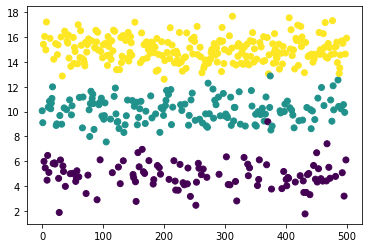

In [2]:
n_components = 3
n_observations = 500
tab = pd.read_csv('testData.csv')
data = torch.tensor(tab['data'], dtype = torch.float32)
b = torch.tensor(tab['b'].astype(int))
plt.scatter(range(len(data)), data, c = b)

Our model using the Cateogorical distribution to assign observations to components:

In [3]:
@config_enumerate
def model(data, n_components, n_observations, i):
    
    ps = pyro.sample('ps', dist.Dirichlet(torch.ones(n_components)/10.))
    mus = pyro.sample('mus', dist.Gamma(20,2).expand([n_components]).to_event(1))
    with pyro.plate('observations', n_observations):
        b = pyro.sample('b', dist.Categorical(probs = ps))                    
        mean = mus[b]    
        pyro.sample("data_target", dist.Normal(loc = mean, scale = torch.tensor(1.)), obs = data)

Define custom guide:

In [4]:
# Make appropriate auto guide (and hiding discrete variable)
guide = AutoLowRankMultivariateNormal(poutine.block(model, hide=['b']))

Training:

In [5]:
# Train model:
n_iterations = 2000
optim = pyro.optim.Adam({'lr': 0.01})
elbo = TraceEnum_ELBO()
svi = SVI(model, guide, optim, loss=elbo)
for i in range(n_iterations):
    loss = svi.step(data, n_components, n_observations, i)

posterior = Predictive(model, guide=guide, num_samples=1)(data, n_components, n_observations, i)

In [6]:
# Predict components:
guide_trace = poutine.trace(guide).get_trace(data, n_components, n_observations, i)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals
def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data, n_components, n_observations, i)
    return trace.nodes["b"]["value"]
b_inferred = classifier(data)

Evaluate model (check all permutations of classes):

In [7]:
score = np.zeros(6)
b_inferred = classifier(data)
score[0] = np.array(torch.sum(b - b_inferred  == 0)/len(b))
b_inferred_switched1 = classifier(data)
b_inferred_switched1[b_inferred_switched1 == 0] = 1
b_inferred_switched1[b_inferred == 1] = 0
score[1] = np.array(torch.sum(b - b_inferred_switched1  == 0)/len(b))
b_inferred_switched2 =  classifier(data)
b_inferred_switched2[b_inferred_switched2 == 2] = 1
b_inferred_switched2[b_inferred == 1] = 2
score[2] = np.array(torch.sum(b - b_inferred_switched2  == 0)/len(b))
b_inferred_switched3 =  classifier(data)
b_inferred_switched3[b_inferred_switched3 == 0] = 2
b_inferred_switched3[b_inferred == 2] = 0
score[3] = np.array(torch.sum(b - b_inferred_switched3  == 0)/len(b))
b_inferred_switched4 = classifier(data)
b_inferred_switched4[b_inferred_switched4 == 0] = 1
b_inferred_switched4[b_inferred == 1] = 0
subset = b_inferred_switched4 == 2
b_inferred_switched4[b_inferred_switched4 == 0] = 2
b_inferred_switched4[subset] = 0
score[4] = np.array(torch.sum(b - b_inferred_switched4  == 0)/len(b))
b_inferred_switched5 = classifier(data)
b_inferred_switched5[b_inferred_switched5 == 0] = 2
b_inferred_switched5[b_inferred == 2] = 0
subset = b_inferred_switched5 == 1
b_inferred_switched5[b_inferred_switched5 == 0] = 1
b_inferred_switched5[subset] = 0
score[5] = np.array(torch.sum(b - b_inferred_switched5  == 0)/len(b))

In [8]:
print('Percentage correctly classified: ', np.max(score))

Percentage correctly classified:  0.9900000095367432


Inferred classes:

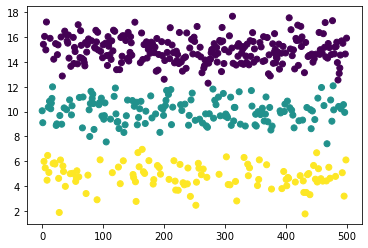

In [9]:
plt.scatter(range(len(data)), data, c = b_inferred)

True classes:

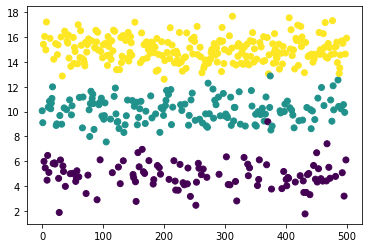

In [10]:
plt.scatter(range(len(data)), data, c = b)